# Final Project

## Author: Cho Laam Yuen

## Load Data and Packages

In [1]:
#connect to my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#change working directory
%cd /content/drive/My\ Drive/Adv\ ML/gr5074-final-project-ChoLaamY/
!pwd

/content/drive/My Drive/Adv ML/gr5074-final-project-ChoLaamY
/content/drive/My Drive/Adv ML/gr5074-final-project-ChoLaamY


In [2]:
#load my libraries
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

In [6]:
#code taken from example code for Covid_Image_Classification (HW2)
#extracting all filenames iteratively
base_path = 'thumbnails'
categories = ['Automobile', 'Blog', 'Comedy', 'Entertainment', 'Food', 'Informative', 'News', 'Science', 'Tech', 'VideoGames']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [261, 184, 168, 193, 268, 242, 193, 281, 260, 253]
[['thumbnails/Automobile/XUhXLsrZiE0.jpg', 'thumbnails/Automobile/9-41nLtleX0.jpg', 'thumbnails/Automobile/rKtFJxGzJX8.jpg', 'thumbnails/Automobile/PV1MlxtpIJs.jpg', 'thumbnails/Automobile/n30DARxk9A4.jpg', 'thumbnails/Automobile/8I-6_H0haAw.jpg', 'thumbnails/Automobile/6Lj_gFyI1Qs.jpg', 'thumbnails/Automobile/L_6SAsypMNM.jpg', 'thumbnails/Automobile/lf8daKt3UlY.jpg', 'thumbnails/Automobile/Quvby2Me5CM.jpg', 'thumbnails/Automobile/CFXfSBR5Q9w.jpg', 'thumbnails/Automobile/o690DovjDAc.jpg', 'thumbnails/Automobile/wZLvLDknpPs.jpg', 'thumbnails/Automobile/VpNX324owaQ.jpg', 'thumbnails/Automobile/_9qJ3rwwTDs.jpg', 'thumbnails/Automobile/kNZV3Bry5UU.jpg', 'thumbnails/Automobile/4-XDxCb92X4.jpg', 'thumbnails/Automobile/KTeXDOC_fRg.jpg', 'thumbnails/Automobile/daQcxVqQJsI.jpg', 'thumbnails/Automobile/DPthR7Z0um0.jpg', 'thumbnails/Automobile/iBy6XRHPODQ.jpg', 'thumbnails/Automobile/XRNv2yXqmaU.jpg', 'thumbnai

## Preprocess Data and Setup

In [18]:
#writing the preprocessor
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(320, 180)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        #grayscale image?  Use im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.  

        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X


In [19]:
#check whether the preprocessor worked
#(Height, Width, Channels)
preprocessor('thumbnails/Blog/_IOZbJ7PCPk.jpg').shape

(180, 320, 3)

In [23]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]+fnames[3]+fnames[4]+fnames[5]+fnames[6]+fnames[7]+fnames[8]+fnames[9]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [24]:
#check length of files matched number of images in my dataset
len(image_filepaths)
print(len(X) ) #same number of images in dataset
print(X.shape ) #dimensions should be 180, 320, 3 for all images
print(X.min() ) #min value of every image is 0
print(X.max() ) #max value of every image is 1


2303
(2303, 180, 320, 3)
0.0
1.0


In [25]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# 10 folders with the corresponding number of images in each folder

print('number of images for each category:', [len(f) for f in fnames])
Automobile=list(repeat('Automobile', 261))
Blog=list(repeat('Blog', 184))
Comedy=list(repeat('Comedy', 168))
Entertainment=list(repeat('Entertainment', 193))
Food=list(repeat('Food', 268))
Informative=list(repeat('Informative', 242))
News=list(repeat('News', 193))
Science=list(repeat('Science', 281))
Tech=list(repeat('Tech', 260))
VideoGames=list(repeat('VideoGames', 253))


#combine into single list of y labels
y_labels = Automobile+Blog+Comedy+Entertainment+Food+Informative+News+Science+Tech+VideoGames

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [261, 184, 168, 193, 268, 242, 193, 281, 260, 253]
2303


,Automobile,Blog,Comedy,Entertainment,Food,Informative,News,Science,Tech,VideoGames
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2298,0,0,0,0,0,0,0,0,0,1
2299,0,0,0,0,0,0,0,0,0,1
2300,0,0,0,0,0,0,0,0,0,1
2301,0,0,0,0,0,0,0,0,0,1


In [26]:
#train test split the dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 874920)

#check y_test set
y_test.sum()

Automobile       52
Blog             37
Comedy           33
Entertainment    39
Food             54
Informative      48
News             39
Science          56
Tech             52
VideoGames       51
dtype: int64

## Visualizing the Thumbnails

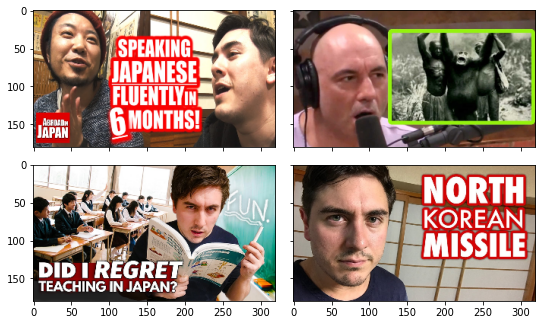

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

img1 = preprocessor('thumbnails/Blog/_IOZbJ7PCPk.jpg')
img2 = preprocessor('thumbnails/Blog/-xfra2_tVF8.jpg')
img3 = preprocessor('thumbnails/Blog/5VDnj8IEWNc.jpg')
img4 = preprocessor('thumbnails/Blog/5VmCvChcGzU.jpg')

fig = plt.figure(figsize=(9., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, img in zip(grid, [img1, img2, img3, img4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(img)
plt.show()